<a href="https://colab.research.google.com/github/tranhuuan1703/Application-Faster-RCNN-model-to-cervical-cancer-cells-detection/blob/main/libraries_model_faster_rcnn_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
# Import libraries
# preprecessing dataset
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image, ImageFont
from torchvision.utils import ImageDraw
# split data and get url image
from sklearn.model_selection import train_test_split
import time
import os

# library pytorch
from tqdm.auto import tqdm

import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

from tempfile import TemporaryDirectory


print("Import sucessfuly!!!")

Import sucessfuly!!!


# perprocessing image

In [ ]:
url = "/content/drive/MyDrive/data_sciences_internship/im_Dyskeratotic/im_Dyskeratotic/017.bmp"

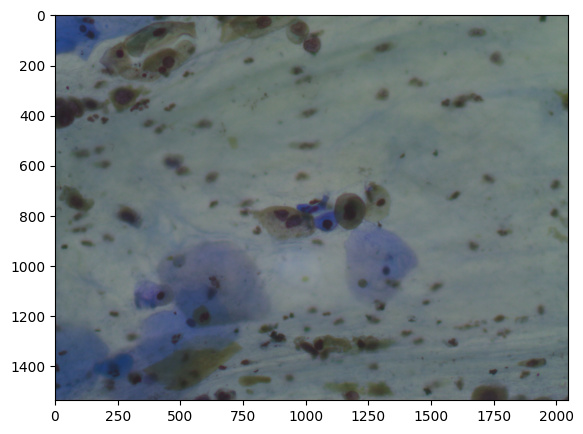

In [ ]:
img = cv2.imread(url)
fig = plt.figure(figsize=(15, 5))
plt.imshow(img)
plt.show()

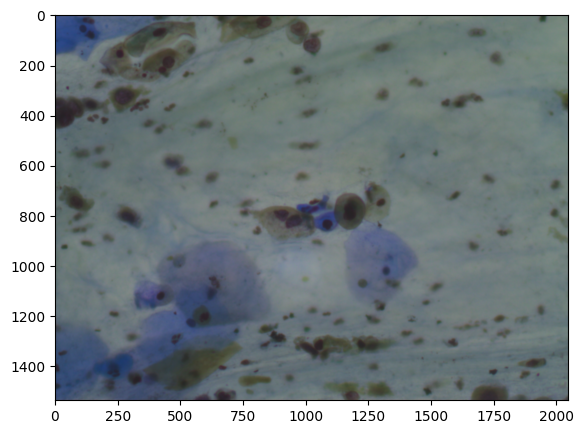

In [ ]:
blurred_image = cv2.blur(img, (5, 5))
fig = plt.figure(figsize=(15, 5))
plt.imshow(blurred_image)
plt.show()

# Read file csv

In [ ]:
# Read file csv
df = pd.read_csv("/content/drive/MyDrive/Muiltple-class Object detection cell canncer/cell_data_20_7.csv")

# Convert label to label encode
df['label_encoded'] = df['label'].astype('category').cat.codes

# Caculator weight, height of bouding box
def diff(a, b):
    return a - b
df['weight'] = df.apply(lambda x: diff(x['x_max'], x['x_min']), axis=1)
df['height'] = df.apply(lambda x: diff(x['y_max'], x['y_min']), axis=1)

# caculator area of bouding box
def multiplication(a, b):
  return a*b
df['area'] = df.apply(lambda x: multiplication(x['weight'], x['height']), axis=1)

In [ ]:
# overview data
print("Info data", df.info(), "\n==================Sample data===============\n")
df.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     4049 non-null   int64 
 1   url            4049 non-null   object
 2   x_min          4049 non-null   int64 
 3   y_max          4049 non-null   int64 
 4   x_max          4049 non-null   int64 
 5   y_min          4049 non-null   int64 
 6   label          4049 non-null   object
 7   ID             4049 non-null   object
 8   label_encoded  4049 non-null   int8  
 9   weight         4049 non-null   int64 
 10  height         4049 non-null   int64 
 11  area           4049 non-null   int64 
dtypes: int64(8), int8(1), object(3)
memory usage: 352.0+ KB
Info data None 
==================Sample data===============



,Unnamed: 0,url,x_min,y_max,x_max,y_min,label,ID,label_encoded,weight,height,area
1327,1327,024.bmp,290,293,342,250,im_Metaplastic,im_Metaplastic_024.bmp,2,52,43,2236
2860,2860,101.bmp,345,339,379,299,im_Parabasal,im_Parabasal_101.bmp,3,34,40,1360
2563,2563,063.bmp,467,328,525,284,im_Parabasal,im_Parabasal_063.bmp,3,58,44,2552
3435,3435,095.bmp,153,597,263,474,im_Superficial-Intermediate,im_Superficial-Intermediate_095.bmp,4,110,123,13530
2001,2001,214.bmp,531,502,560,471,im_Dyskeratotic,im_Dyskeratotic_214.bmp,0,29,31,899
1181,1181,254.bmp,330,495,398,404,im_Metaplastic,im_Metaplastic_254.bmp,2,68,91,6188
1481,1481,078.bmp,455,288,489,229,im_Metaplastic,im_Metaplastic_078.bmp,2,34,59,2006
1469,1469,074.bmp,249,304,300,233,im_Metaplastic,im_Metaplastic_074.bmp,2,51,71,3621
152,152,128.bmp,270,215,304,181,im_Koilocytotic,im_Koilocytotic_128.bmp,1,34,34,1156
756,756,098.bmp,266,322,304,267,im_Koilocytotic,im_Koilocytotic_098.bmp,1,38,55,2090


# Custom dataset

In [ ]:
# Custome data
class cust_data(torch.utils.data.Dataset):
  def __init__(self, image_list, df, transform=None):
    """
      Input: list image by ID, datafrane, function augmentation image.
      output: Image, target Image
        Image: (640, 640, 3)
        target: {
                  Boxes: [[x_min, y_min, x_max, y_max],
                          [x_min, y_min, x_max, y_max], ...],
                  Labels: tensor([label, label]), quatity of labels equa quatity bouding box.
                  area: tensor([area1, area2, ...]) quatity of area equa quatity bouding box.
        }
    """
    self.image_list = image_list
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, idx):

    url = "/content/drive/MyDrive/data_sciences_internship/"
    df_item = self.df.loc[self.df['ID'] == self.image_list[idx], ['url', "x_min", "y_min",	"x_max", "y_max", "label", "label_encoded", "area"]].values
    # get feature
    image_name = df_item[0, 0]
    boxes = df_item[:, 1: 5].astype("float32")
    labels = df_item[:, 6].astype("int64")
    label = df_item[:, 5]
    image_path = url + "/" + label[0] + "/" + label[0] + "/" +  image_name
    area = df_item[:, 7].astype("float32")



    # reading the images and converting them to correct size and color
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_resize = cv2.resize(img_rgb, (640, 640), cv2.INTER_AREA)
    img_resize = cv2.blur(img_resize, (5, 5))
    # diving by 255
    img_resize /= 255.0

    if self.transform:
      sample = self.transform(image = img_resize,
                            bboxes = boxes,
                            labels = labels,
                            area = area)

      img_res = sample['image']
      boxes_tensor = torch.tensor(sample['bboxes'], dtype=torch.float32)
      labels_tensor = torch.tensor(sample['labels'], dtype=torch.int64)
      target = {}
      target['boxes'] = boxes_tensor
      target['labels'] = labels_tensor


      target["area"] = torch.tensor(sample['area'], dtype=torch.float32)

    else:
      img_res = img_resize
      target = {}
      target['boxes'] = boxes_tensor
      target['labels'] = labels_tensor
      # image_id

      target["area"] = area


    return img_res, target

In [ ]:
shuffled_df = df.sample(frac=1, random_state=42)
train_inds = shuffled_df[:483]["ID"].unique()
test_inds = shuffled_df[483:724]["ID"].unique()
val_inds = shuffled_df[724:]["ID"].unique()

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0})

# use our dataset and defined transformations
dataset = cust_data(train_inds, df, transform= get_transform(train=True))
dataset_test = cust_data(test_inds, df, transform= get_transform(train=False))
dataset_val = cust_data(val_inds, df, transform= get_transform(train=False))

In [ ]:
# Loading the First Batch and Printing Information
for idx, batch in enumerate(dataset):
    print('Batch index: ', idx)
    print('Batch size: ', batch[0].size())
    print('Batch boxes: ', batch[1]['boxes'])
    print('Batch labels:', batch[1]['labels'])
    print('Bactch area:', batch[1]['area'])
    break

Batch index:  0
Batch size:  torch.Size([3, 640, 640])
Batch boxes:  tensor([[526., 223., 571., 281.],
        [ 93., 333., 148., 394.],
        [161., 343., 228., 403.]])
Batch labels: tensor([2, 2, 2])
Bactch area: tensor([2610., 3355., 4020.])


In [ ]:
for idx, batch in enumerate(dataset):
  print(type(batch))
  print(len(batch))
  print(batch)
  print(idx)
  break

<class 'tuple'>
2
(tensor([[[0.1320, 0.1308, 0.1323,  ..., 0.3397, 0.3407, 0.3451],
         [0.1316, 0.1311, 0.1320,  ..., 0.3586, 0.3643, 0.3744],
         [0.1336, 0.1330, 0.1332,  ..., 0.3879, 0.3990, 0.4154],
         ...,
         [0.6077, 0.6086, 0.6062,  ..., 0.6014, 0.6004, 0.5966],
         [0.6086, 0.6083, 0.6049,  ..., 0.5981, 0.5950, 0.5911],
         [0.6069, 0.6070, 0.6036,  ..., 0.5974, 0.5937, 0.5896]],

        [[0.2668, 0.2610, 0.2414,  ..., 0.2776, 0.2675, 0.2622],
         [0.2639, 0.2575, 0.2392,  ..., 0.2916, 0.2882, 0.2898],
         [0.2471, 0.2427, 0.2281,  ..., 0.3067, 0.3074, 0.3148],
         ...,
         [0.7071, 0.7073, 0.7075,  ..., 0.6850, 0.6815, 0.6777],
         [0.7061, 0.7064, 0.7072,  ..., 0.6850, 0.6809, 0.6759],
         [0.7062, 0.7066, 0.7076,  ..., 0.6826, 0.6780, 0.6728]],

        [[0.3750, 0.3657, 0.3438,  ..., 0.4150, 0.4172, 0.4155],
         [0.3682, 0.3598, 0.3391,  ..., 0.4200, 0.4234, 0.4225],
         [0.3496, 0.3426, 0.3253,  ...,

In [ ]:
# # create dataloader train and test
# pin_memory=True if torch.cuda.is_available() else False
# pin_memory=True if torch.cuda.is_available() else False
# pin_memory=True if torch.cuda.is_available() else False
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=16, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
print("data loader")

data loader


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# load a model pre-trained pre-trained on COCO
num_classes = 5
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 361MB/s]


In [ ]:
device = torch.device("cuda") # use GPU to train
model = model.to(device)

In [ ]:
rate_learning = 1e-4
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
optimizer = torch.optim.Adam(params, lr=rate_learning)

In [ ]:
import math
import sys
from sklearn.metrics import average_precision_score

In [ ]:
def calculate_iou(box1, box2):
    # Calculate the intersection area
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate the union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Calculate IOU
    iou = intersection_area / union_area
    return iou

def map(model, data_loader, iou_threshold=0.5):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data, target in data_loader:
            imgs = [d.to(device) for d in data]
            targets = []
            for ta in target:
              targ = {}
              targ['boxes'] = ta['boxes'].to(device)
              targ['labels'] = ta['labels'].to(device)

              targets.append(targ)

            # Forward pass to get predictions
            predictions = model(imgs)

            for idx, prediction in enumerate(predictions):
                true_boxes = targets[idx]['boxes'].cpu().numpy()
                predicted_boxes = prediction['boxes'].cpu().numpy()

                for true_box in true_boxes:
                    for pred_box in predicted_boxes:
                        iou = calculate_iou(true_box, pred_box)
                        if iou > iou_threshold:
                            correct_predictions += 1
                            break

                total_predictions += len(true_boxes)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch, eval_loader):
    model.to(device)
    model.train()
    all_losses = []
    all_losses_dict = []
    list_map = []
    loss_classifier_lst = []
    loss_box_reg_lst = []
    loss_rpn_box_reg_lst = []
    loss_objectness_lst = []
    all_loss_lst = []
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    if epoch==5:
      torch.save(model, "/content/drive/MyDrive/test_libraries_model_faster_rcnn/model.pth")

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    map_score = map(model, eval_loader)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}, Validation mAP: {:.4f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean(),
        map_score
    ))

    print("=====================")
    return [map_score, np.mean(all_losses), all_losses_dict['loss_classifier'].mean(), all_losses_dict['loss_box_reg'].mean(), all_losses_dict['loss_rpn_box_reg'].mean(), all_losses_dict['loss_objectness'].mean()]

In [ ]:
num_epochs=15
list_map=[]
all_loss_lst=[]
loss_classifier_lst=[]
loss_box_reg_lst=[]
loss_rpn_box_reg_lst = []
loss_objectness_lst=[]
all_loss_lst = []
for epoch in range(num_epochs):
    result = train_one_epoch(model, optimizer, data_loader, device, epoch, data_loader_val)
    list_map.append(result[0])
    all_loss_lst.append(result[1])
    loss_classifier_lst.append(result[2])
    loss_box_reg_lst.append(result[3])
    loss_rpn_box_reg_lst.append(result[4])
    loss_objectness_lst.append(result[5])


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 0, lr: 0.000100, loss: 0.835598, loss_classifier: 0.414116, loss_box: 0.316222, loss_rpn_box: 0.017654, loss_object: 0.087606, Validation mAP: 0.8089


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 1, lr: 0.000100, loss: 0.583736, loss_classifier: 0.281101, loss_box: 0.256360, loss_rpn_box: 0.013063, loss_object: 0.033211, Validation mAP: 0.8109


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 2, lr: 0.000100, loss: 0.461492, loss_classifier: 0.208055, loss_box: 0.216847, loss_rpn_box: 0.011140, loss_object: 0.025449, Validation mAP: 0.8839


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 3, lr: 0.000100, loss: 0.378939, loss_classifier: 0.168417, loss_box: 0.181634, loss_rpn_box: 0.008852, loss_object: 0.020036, Validation mAP: 0.8902


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 4, lr: 0.000100, loss: 0.349652, loss_classifier: 0.161161, loss_box: 0.165879, loss_rpn_box: 0.007607, loss_object: 0.015004, Validation mAP: 0.7656


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 5, lr: 0.000100, loss: 0.285964, loss_classifier: 0.123300, loss_box: 0.145193, loss_rpn_box: 0.006525, loss_object: 0.010946, Validation mAP: 0.7761


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 6, lr: 0.000100, loss: 0.248188, loss_classifier: 0.101233, loss_box: 0.132424, loss_rpn_box: 0.006013, loss_object: 0.008518, Validation mAP: 0.8066


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 7, lr: 0.000100, loss: 0.220851, loss_classifier: 0.093496, loss_box: 0.116553, loss_rpn_box: 0.005238, loss_object: 0.005564, Validation mAP: 0.7868


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 8, lr: 0.000100, loss: 0.222570, loss_classifier: 0.091681, loss_box: 0.116517, loss_rpn_box: 0.005447, loss_object: 0.008926, Validation mAP: 0.7338


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 9, lr: 0.000100, loss: 0.167623, loss_classifier: 0.057830, loss_box: 0.101489, loss_rpn_box: 0.004233, loss_object: 0.004071, Validation mAP: 0.7098


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 10, lr: 0.000100, loss: 0.142769, loss_classifier: 0.047044, loss_box: 0.088881, loss_rpn_box: 0.003706, loss_object: 0.003138, Validation mAP: 0.6390


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 11, lr: 0.000100, loss: 0.145446, loss_classifier: 0.046007, loss_box: 0.093028, loss_rpn_box: 0.003469, loss_object: 0.002941, Validation mAP: 0.7120


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 12, lr: 0.000100, loss: 0.130983, loss_classifier: 0.041282, loss_box: 0.083777, loss_rpn_box: 0.003150, loss_object: 0.002774, Validation mAP: 0.6350


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 13, lr: 0.000100, loss: 0.116183, loss_classifier: 0.035119, loss_box: 0.076152, loss_rpn_box: 0.003064, loss_object: 0.001849, Validation mAP: 0.6868


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-18-911ee223ebd6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch 14, lr: 0.000100, loss: 0.109730, loss_classifier: 0.033524, loss_box: 0.071308, loss_rpn_box: 0.003016, loss_object: 0.001883, Validation mAP: 0.6357


In [ ]:
result

[0.6357267950963222,
 0.10972954222763126,
 0.03352353002198718,
 0.07130785201760856,
 0.0030155837726355953,
 0.0018825755002829035]

In [ ]:
epochs = [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 15]
list_plot = [list_map,
all_loss_lst,
loss_classifier_lst,
loss_box_reg_lst,
loss_rpn_box_reg_lst,
loss_objectness_lst,
all_loss_lst]

In [ ]:
epochs = [1,2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
list_plot_title = ["list_map", "all_loss_lst", "loss_classifier_lst", "loss_box_reg_lst", "loss_rpn_box_reg_lst", "loss_objectness_lst", "all_loss_lst"]

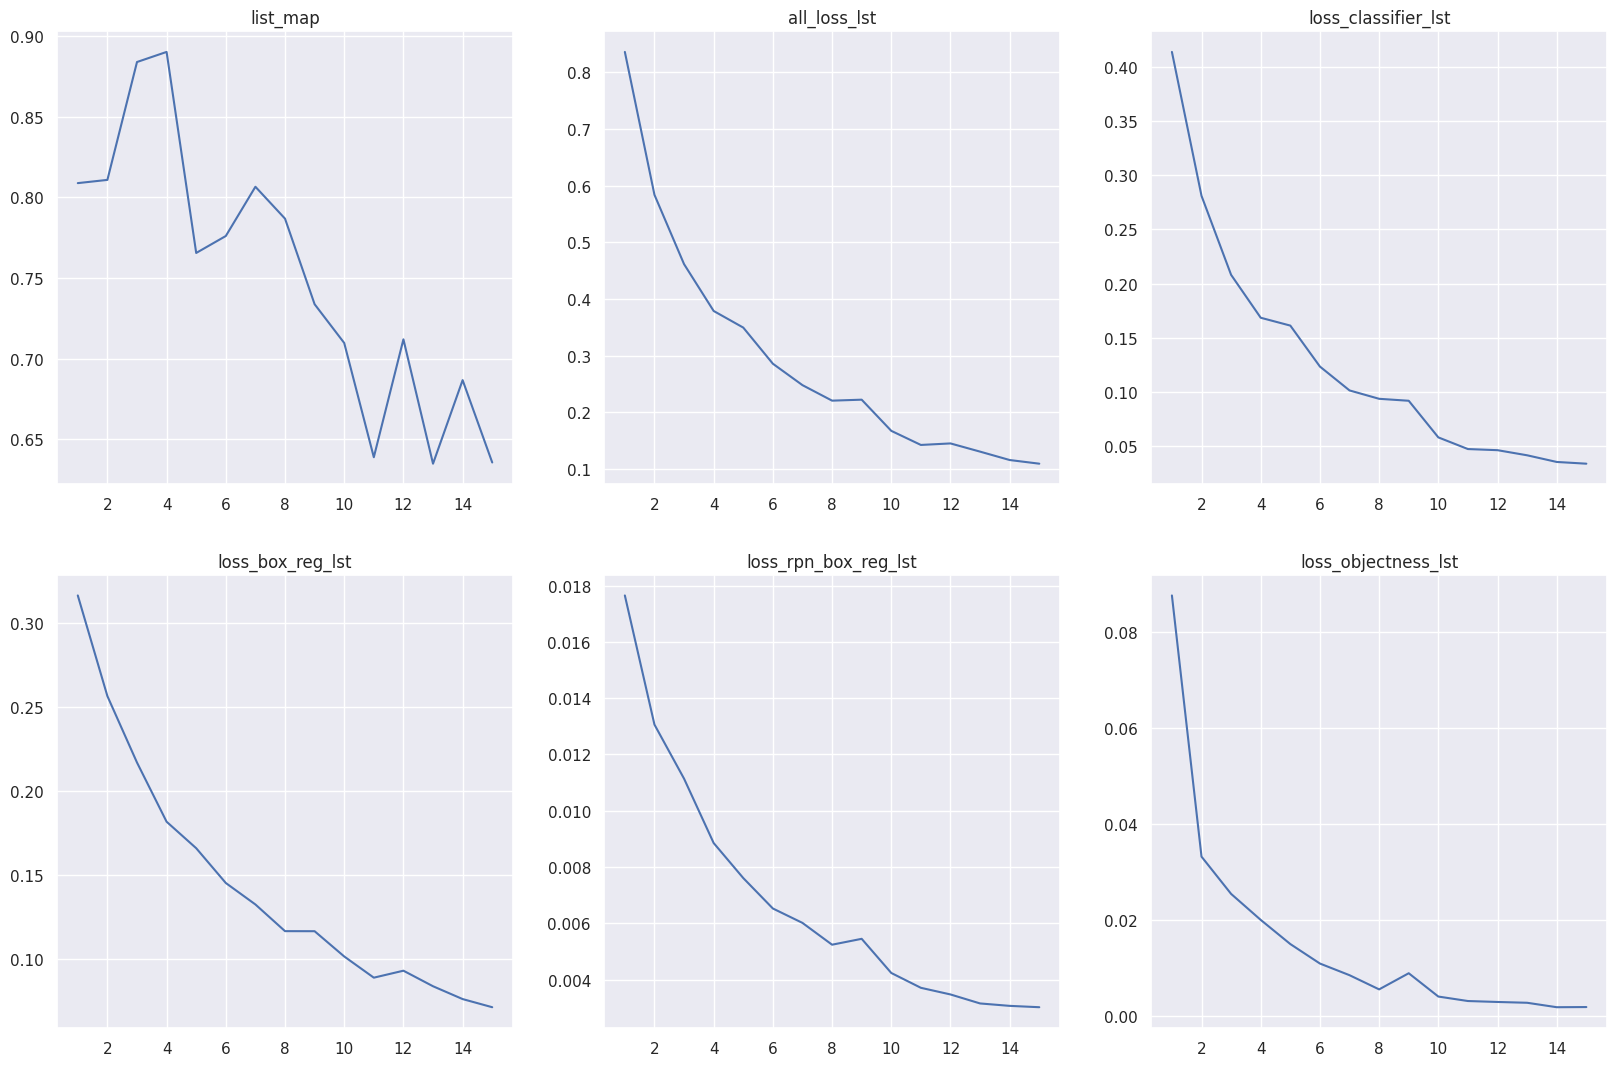

In [ ]:
fig  = plt.figure(figsize=(20, 20))
for i in range(6):
  plt.subplot(3, 3, i+1)
  plt.plot(epochs, list_plot[i])
  plt.title(list_plot_title[i])
plt.show()

In [ ]:
list_map

[0.8088566424818614,
 0.8108581436077058,
 0.8839129347010257,
 0.8901676257192894,
 0.7655741806354766,
 0.7760820615461597,
 0.8066049537152865,
 0.7868401300975731,
 0.7338003502626971,
 0.7097823367525644,
 0.6389792344258194,
 0.7120340255191393,
 0.6349762321741306,
 0.686765073805354,
 0.6357267950963222]